In [2]:
# Importing Built Tools such as Notion , Slack
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END , START
# from langgraph.checkpoint import MemorySaver
from IPython.display import Image, display
from typing import Optional , Literal , TypedDict
from datetime import datetime
import re
import os
from dotenv import load_dotenv


from notion_api_tools import fetch_notion_page_content , append_toggle_with_bullets_for_change_log , update_block_content , delete_block , append_bulleted_list_to_block
from slack_tools import retrieve_channel_id_by_name , post_message_to_channel , fetch_replies_from_channel



class MyAgentState1(TypedDict):
    latest_meeting_topic : Optional[str]
    latest_email_meeting_summary : Optional[str]
    latest_action_items_data : Optional[str]
    structured_refined_email_summary : Optional[list]
    structured_list_of_action_items : Optional[list]
    notion_page_ids_list: Optional[list[dict]]
    slack_channel_id : Optional[str]
    slack_bot_id : Optional[str]
    pre_existing_notion_page_data: Optional[list]
    suggested_structured_changes: Optional[list]
    next_node: Optional[str]  # Add this to track the next node
    new_page_content_list : Optional[list]
    need_existance_projects_details_list : Optional[list]


In [3]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [8]:
from notion_api_tools import add_page_to_action_items_database_table_by_id , get_each_notion_page_action_items_table_id_mapping


def process_changes(data_list):
        today_date = datetime.today().strftime('%Y-%m-%d')
        notion_page_to_action_items_table_id_matching = get_each_notion_page_action_items_table_id_mapping()
        
        for entry in data_list:
            page_id = entry.get("page_id")
            changes = entry.get("changes", [])
            change_logs = entry.get("changeLogs", [])
            suggested_action_items_list = entry.get("suggested_action_items_add" , [])
            
            for change in changes:
                block_id = change.get("objectId")
                change_type = change.get("ChangeType")
                content = change.get("ContentForChange")
                
                if change_type == "update":
                    update_block_content.invoke(input = { "updating_block_info"  :  {"blockId": block_id, "new_text_content": content}})
                elif change_type == "delete":
                    delete_block.invoke(input = {"deleting_block_info" : {"blockId": block_id}})
                elif change_type == "append":
                    append_bulleted_list_to_block.invoke(input = {"adding_content_info" : {"blockId": block_id, "bullet_points_list": [content]}})
            
            if change_logs:
                append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                    "NOTION_PAGE_ID": page_id,
                    "toggle_item_text": f"Change Log {today_date}",
                    "bullet_points_list": change_logs
                }})
            # action_item_data = {"action_item" : "This is to do by EOD" , "status" : "Not Started" , "assigned_to" : ["person-1" , "person-2"]}
            if suggested_action_items_list:
                for each_action_item_info in suggested_action_items_list:
                     temp_dict = {"action_item" : each_action_item_info.get("action_item_text") , "status" : each_action_item_info.get("status") , "assigned_to" : each_action_item_info.get("assignees")}
                     # now we should import a function here 
                     add_page_to_action_items_database_table_by_id(notion_page_to_action_items_table_id_matching.get(page_id) , temp_dict)

# # lets make it as tool ,llm decide to use this tool for every notionPage Suggested changes  #TOOL
# def process_changes(suggested_change_to_notion_dict):
#         today_date = datetime.today().strftime('%Y-%m-%d')
#         notion_page_to_action_items_table_id_matching = get_each_notion_page_action_items_table_id_mapping()
        

#         page_id = suggested_change_to_notion_dict.get("page_id")
#         changes = suggested_change_to_notion_dict.get("changes", [])
#         change_logs = suggested_change_to_notion_dict.get("changeLogs", [])
#         suggested_action_items_list = suggested_change_to_notion_dict.get("suggested_action_items_add" , [])
        
#         for change in changes:
#             block_id = change.get("objectId")
#             change_type = change.get("ChangeType")
#             content = change.get("ContentForChange")
            
#             if change_type == "update":
#                 update_block_content.invoke(input = { "updating_block_info"  :  {"blockId": block_id, "new_text_content": content}})
#             elif change_type == "delete":
#                 delete_block.invoke(input = {"deleting_block_info" : {"blockId": block_id}})
#             elif change_type == "append":
#                 append_bulleted_list_to_block.invoke(input = {"adding_content_info" : {"blockId": block_id, "bullet_points_list": [content]}})
        
#         if change_logs:
#             append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
#                 "NOTION_PAGE_ID": page_id,
#                 "toggle_item_text": f"Change Log {today_date}",
#                 "bullet_points_list": change_logs
#             }})
#         # action_item_data = {"action_item" : "This is to do by EOD" , "status" : "Not Started" , "assigned_to" : ["person-1" , "person-2"]}
#         if suggested_action_items_list:
#             for each_action_item_info in suggested_action_items_list:
#                  temp_dict = {"action_item" : each_action_item_info.get("action_item_text") , "status" : each_action_item_info.get("status") , "assigned_to" : each_action_item_info.get("assignees")}
#                  # now we should import a function here 
#                  add_page_to_action_items_database_table_by_id(notion_page_to_action_items_table_id_matching.get(page_id) , temp_dict)

In [11]:
from notion_api_tools import add_heading_to_page , add_bulleted_list_with_subpoints , append_new_topic_toggle_under_given_toggle_id , append_toggle_to_given_page , append_toggle_with_bullets_for_change_log , create_notion_table , add_new_notion_page_data_to_existing_notion_pages_database , get_each_notion_page_action_items_table_id_mapping , add_each_notion_page_action_items_table_id_mapping
from datetime import datetime


def applying_new_topics_in_new_notion_page(notion_page_id ,latest_meeting_topic, latest_notes_list , extracted_action_items_list ):


    today_date = datetime.today().strftime('%Y-%m-%d')
    
    # step-1 :-  Applying Heading
    add_heading_to_page(notion_page_id , "This is related to Change Log")

    #step-2 :-  adding Toggle with Chaneg Log
    append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                "NOTION_PAGE_ID": notion_page_id,
                "toggle_item_text": f"Change Log {today_date}",
                "bullet_points_list": ["Added all new Topics"]
            }})

    # step-3 :- 
    latest_notes_toggle_block_id = append_toggle_to_given_page(notion_page_id , "Latest Notes")

    # Appending all topic blocks as children to latest_notes_toggle_block_id

    for each_topic_element in latest_notes_list:
        topic_name = each_topic_element.get("topic")
        sub_topics_list = each_topic_element.get("sub_topics")   # sub_topics_list is a list
        
        topic_toggle_block_id = append_new_topic_toggle_under_given_toggle_id(latest_notes_toggle_block_id , topic_name)

        # appending each-sub-topics with corresponding bullets
        # each_sub_topic has sub_topic name and bullet_points
        
        add_bulleted_list_with_subpoints(topic_toggle_block_id ,sub_topics_list)
    # added adding_action_items_table and inserting each action_item
    # step-4
    created_table_id = create_notion_table(notion_page_id)
    print("At creation of Action Items table")
    for each_action_item in extracted_action_items_list:
        each_action_item_info = {
            "action_item" : each_action_item.get("action_item_text"),
            "status" : each_action_item.get("status"),
            "assigned_to" : each_action_item.get("assignees")
        }
        # action_item_text = each_action_item.get("action_item_text")
        # status = each_action_item.get("status")
        # assignees_list = each_action_item.get("assignees")
        add_page_to_action_items_database_table_by_id(created_table_id , each_action_item_info)
    print("adding content new Notion Page completed , storing details of newly created Notion Page")
    # adding newly created Notion Page Info
    add_new_notion_page_data_to_existing_notion_pages_database(notion_page_id , latest_meeting_topic)
    print("Tryong to add New Notion Page Id mapping to created Action Items Table , Should be defined")
    add_each_notion_page_action_items_table_id_mapping(notion_page_id ,created_table_id)

In [5]:
from slack_tools import handle_sending_msg
from notion_api_tools import validate_notion_page

#checking whether notion page id is valid or not
# Can be made it as a tool for LLM , if it found need_existance , then it can use this to send msgs
async def get_valid_notion_page(state):
    
    while True:
        try:
            human_response = await handle_sending_msg(state["latest_meeting_topic"])
            print(f"📩 Received Notion Page ID: {human_response}")

            if human_response and await validate_notion_page(human_response):
                print("✅ Notion Page ID is valid!")
                return human_response
            else:
                print("❌ Notion Page ID is invalid. Asking admin again...")
                await handle_sending_msg("The Notion Page ID is invalid. Please provide a correct one.")

        except Exception as e:
            print(f"❌ Error while validating Notion Page: {e}")

In [4]:
from notion_api_tools import fetch_data_from_meetings_history_database_table ,fetch_data_from_notion_pages_data_database_table, fetch_notion_page_content , append_bulleted_list_to_block
import json
import re
import time
from notion_api_tools import update_block_content , delete_block , append_toggle_with_bullets_for_change_log  # ,  append_bulleted_list_to_block
from datetime import datetime
from slack_tools import handle_sending_msg

llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai_api_key)


def getting_meeting_from_email(state :MyAgentState1)-> MyAgentState1 :

    print("Here we will get both Topic and Latest Email Summary as Input from Agent Invoking")
    print("Invoked getting_meeting_from_email")
    print("Getting latest Meeting to Invoke Agent")
    # state["latest_meeting_topic"] = "Hive Reviews and Demos"
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print(f"Latest Meeting topic got is {state["latest_meeting_topic"]}")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("LATEST MEETING SUMMARY IS \n")
    print(state["latest_email_meeting_summary"])
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("\nLATEST ACTION ITEMS DATA\n")
    print(state["latest_action_items_data"])
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")

    return state


# This is related to deciding whether the LMS meeting name matches with old_meetings history or not
# Added checking old_meetings history and also notion_pages_data



In [7]:
# This is related to deciding whether the LMS meeting name matches with old_meetings history or not
# Added checking old_meetings history and also notion_pages_data

def checking_new_or_old_topic(state : MyAgentState1) -> MyAgentState1 :
    print("Invoked  checking_new_or_old_topic")
    fetched_past_meetings_info = fetch_data_from_meetings_history_database_table("197e35223beb80039714f0cd468bce2e")
    fetched_existing_notion_pages_info = fetch_data_from_notion_pages_data_database_table()
    print("****************************")
    print(fetched_existing_notion_pages_info)
    print("****************************")
    latest_meeting_topic = state["latest_meeting_topic"]
    latest_meeting_info = {
        "meeting_name" : latest_meeting_topic,
        "happened_date" : "February 11, 2025 at 1:30 PM"
    }

    # existing_notion_pages_info = [
    #     {
    #         "page_id" : "id",
    #         "project_name" : "Marketing Agent"
    #     },
    #     {
    #         "page_id" : "id",
    #         "project_name" : "Documentation Agent"
    #     }
    # ]

    prompt = f"""
    You are an AI assistant responsible for analyzing meeting records and determining whether the latest meeting topic is new or has already been covered in past meetings or existing projects.

    ## **Input Data**:
    1. **Latest Meeting Information**:
    - Meeting Name: "{latest_meeting_info['meeting_name']}"
    - Happened Date: "{latest_meeting_info['happened_date']}"

    2. **Past Meeting Records**:
    The following meetings have already occurred:
    {json.dumps(fetched_past_meetings_info, indent=4)}

    3. **Existing Notion Project Records**:
    These project names currently exist in Notion:
    {json.dumps(fetched_existing_notion_pages_info, indent=4)}

    ## **Classification Conditions**:
    The latest meeting topic should be classified based on the following conditions:
    
    - **Condition 1**: If the latest meeting name **matches** any `meeting_name` in `fetched_past_meetings_info`, it is considered an **existing topic**.
    - **Condition 2**: If the latest meeting name **does not match** any past meetings but **matches** a `page_project_title` in `existing_notion_pages_info`, it is still considered an **existing topic** because it relates to a specific project.
    - **Condition 3**: If the latest meeting name **does not match** any past meeting records (`fetched_past_meetings_info`) **and** does not match any existing notion project records (`existing_notion_pages_info`), it is considered a **new topic**.

    ## **Your Task**:
    1. Compare the **latest meeting name** with:
       - Past meeting records (`fetched_past_meetings_info`).
       - Existing Notion project records (`fetched_existing_notion_pages_info`).
    
    2. Determine the correct classification based on the conditions above.

    3. Respond with a JSON object in the following format:
    
    - If the topic **already exists** (Condition 1 or Condition 2), respond with:
        ```json
        {{
            "status": "existing_topic",
            "matched_meeting_name": "<most relevant past meeting name or existing project>",
            "reason": "The topic matches a past meeting or an existing project discussion.",
            "is_new_topic": "no"
        }}
        ```
    
    - If the topic **is new** (Condition 3), respond with:
        ```json
        {{
            "status": "new_topic",
            "new_topic_name": "<new meeting topic name>",
            "reason": "The topic has not been discussed before.",
            "is_new_topic": "yes"
        }}
        ```

    ## **Output Format (JSON)**:
    Strictly respond with the following JSON format without any additional text:
    ```json
    {{
        "status": "<new_topic/existing_topic>",
        "matched_meeting_name": "<if applicable, provide the most relevant past meeting name or existing topic>",
        "new_topic_name": "<if applicable, provide the new topic name>",
        "reason": "<explanation>",
        "is_new_topic": "<yes/no>"
    }}
    ```
    """
    print("Checking whether Topic is new or Existing by LLM")
    llm_response = llm.invoke(prompt)
    llm_content = llm_response.content
    print("Checking Completed")
    # print(llm_content)
    # changing llm_content to json and extracting is_new_topic 
    cleaned_json_str = re.sub(r'^```json\n|\n```$', '', llm_content.strip())
    try:
        json_data = json.loads(cleaned_json_str)
        print(json_data)
        is_new_topic = json_data.get("is_new_topic" , "")

    except Exception as e:
        print(e)

    state["topic_type"] = is_new_topic
    if is_new_topic == "yes":
        state["next_node"] = "process_new_meeting_topic"
    else :
        state["next_node"] = "getting_structured_meeting_summary"

    # state["next_node"] = "structured_refined_email_summary"
    print(f"Latest Topic Type is {is_new_topic}")
    return state


In [8]:
# This is related to conditional to decide to go either process_new_meeting_topic or getting_structured_meeting_summary based on stored next_node state key

def decide_new_or_changes(state: MyAgentState1) -> str:
    if state.get("next_node") in ["process_new_meeting_topic", "getting_structured_meeting_summary"]:
        return state["next_node"]
    return END


# older version of refined summary  (with which comparision takes place according to project wise)
older_version = {
    "projects": [
        {
            "notion_id": "id1",
            "project_name": "Marketing Agent",
            "details": [
                "The team was in the initial planning phase, evaluating different SEO tools for integration.",
                "Faced challenges in selecting the most compatible SEO tool for automation.",
                "Initial attempts at SEMrush integration resulted in authentication errors.",
                "Explored alternative automation tools but lacked a proper API approach."
            ]
        },
        {
            "notion_id": "id2",
            "project_name": "Documentation Agent",
            "details": [
                "The Documentation Agent was not yet started, pending approval for Notion API usage.",
                "Faced difficulties in understanding Notion API's rate limits and data structuring.",
                "Initial tests showed inconsistencies in retrieving document history.",
                "Action item tracking within Notion was not yet implemented."
            ]
        },
        {
            "notion_id": "page_id",
            "project_name": "BLK Project",
            "details": [
                "The BLK project was in the early research phase with incomplete project scope.",
                "Delays were observed due to unclear requirements and changing priorities.",
                "Team faced challenges in aligning URLs with the required project structure.",
                "Lack of proper tracking mechanisms led to slower progress."
            ]
        },
        {
            "notion_id": "page_id",
            "project_name": "IDP Agent",
            "details": [
                "The IDP Agent development was in an experimental stage with basic document processing.",
                "Early table extraction attempts showed poor accuracy in structured document layouts.",
                "The workflow was mostly static, lacking flexibility for dynamic document formats.",
                "No human-in-the-loop validation mechanism was implemented initially.",
                "Challenges were faced in choosing the right ML models for document classification."
            ]
        }
    ]
}




In [9]:
from notion_api_tools import get_latest_projects_row_data
def getting_structured_meeting_summary(state : MyAgentState1)-> MyAgentState1 :
    # state["structured_refined_email_summary"] = "This is a Structured Refined Email Summary in the form of a list of Dicts where Each Dict consist of Changes and ChangeLog"
    print("Getting a Structured Refined Summary from an LLM in the form of a List of Dicts")
    print("Getting existing Notion Pages Content")

    # pages_id_list = ["18ae35223beb804fbfb3cce77e9a94fb" , "196e35223beb806a8889f2524d28bdaf"]
    pages_id_list = fetch_data_from_notion_pages_data_database_table()
    # pages_id_list = [{notion_page_id : "" , page_project_title : ""}]
    
    notion_pages_data = []
    # overall_notion_data  = ""

    for each_notion_page_info  in pages_id_list:
        notion_page_id = each_notion_page_info.get("notion_page_id")
        each_dict = dict()
        each_dict["page_id"] = notion_page_id
        # notion_page_info = {"notion_page_id": eachPageId}
        # print(f"Debug Notion Page Info: {notion_page_info}")  # Debugging Step
        each_dict["fetched_content"] = str(fetch_notion_page_content.invoke(input = {"notion_page_id_info" : {"notion_page_id" :notion_page_id }} ))
        notion_pages_data.append(each_dict)
        print("🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢")
        # print(each_dict["fetched_content"])
    print("Fetching Data from All Notion Pages Completed")
    state["pre_existing_notion_page_data"] = notion_pages_data   # list of strings

    for each_dict in state["pre_existing_notion_page_data"]:
        print("*********************")
        print(each_dict["page_id"])
        print(each_dict["fetched_content"])
        print("*************************")
    print("All Fetching completed , now it will be precessed by LLM to get list of changes to be made for each Notion Page")
    # Function which returns corresponding notion_page content by using given page_id , which were stored in notion_pages_data
    def get_respective_notion_page_content_by_page_id(page_id):
        for existed_data in notion_pages_data:
            if existed_data["page_id"] == page_id:
                return existed_data["fetched_content"]

    # Processing Notion Content and comparing with Latest Meeting summary
    # latest_meeting_summary = state["latest_email_meeting_summary"]
    latest_meeting_summary = state["latest_email_meeting_summary"]
    action_items  = state["latest_action_items_data"]
    
    # latest_meeting_summary = "The meeting covered progress updates on various agents, including navigation, marketing, documentation, and IDP agents. Key discussions included the integration of SEMrush, Notion API exploration, and improvements to the IDP agent. Action items were assigned to team members to ensure timely execution and pipeline visibility."
    # action_items = [
    #     {
    #         "user": "Pritesh Singh",
    #         "task": "Prepare a demo for the Excel pipeline to provide team visibility."
    #     },
    #     {
    #         "user": "Keerthi Lakshmi Buchupalli",
    #         "task": "Resolve SEMrush API error and proceed with Selenium-based integration."
    #     },
    #     {
    #         "user": "Ganesh Putta",
    #         "task": "Continue exploring Notion API for documentation updates and action item tracking."
    #     },
    #     {
    #         "user": "Ananya Sahu",
    #         "task": "Optimize IDP agent workflow by incorporating dynamic processing and human-in-the-loop validation."
    #     },
    #     {
    #         "user": "Vaibhav Thakran",
    #         "task": "Enhance IDP agent's table extraction accuracy and explore alternative models."
    #     },
    #     {
    #         "user": "Pritesh Singh",
    #         "task": "Share OpenAI API key with Ananya Sahu for further development."
    #     },
    #     {
    #         "user": "Salmanul Faris",
    #         "task": "Catch up on BLK project deliverables and ensure timely completion of required URLs."
    #     },
    #     {
    #         "user": "Diwakar Joshi",
    #         "task": "Get familiar with assigned agent framework and tools."
    #     }
    # ]
    # action_items = state["latest_action_items_data"]
    # pre_existing_notion_page_data = state["pre_existing_notion_page_data"]

    print("Down Processing Stage")
    all_page_changes = []

    prompt = f"""
You are an AI assistant responsible for structuring meeting insights by mapping the latest meeting summary to relevant projects in Notion. Your task is to analyze the latest refined meeting summary and extracted action items while leveraging the provided `pages_id_list` context.
## **Input Data**:
1. **Latest Refined Meeting Summary**:
{latest_meeting_summary}

2. **Extracted Action Items**:
{json.dumps(action_items, indent=4)}

3. **Existing Notion Project Records (pages_id_list)**:
The list of Notion pages and their corresponding project names:
```json
{json.dumps(pages_id_list, indent=4)}
Your Task:
1. Analyze the latest meeting summary and extracted action items.
2. Utilize pages_id_list to structure the information based on existing Notion project mappings.
3. Identify both pre-existing projects from pages_id_list and new projects that are discussed in the meeting but not found in pages_id_list.
4. For each project (existing or new), generate a structured summary that includes:
    - Clearly describing the project status in a full sentence format (e.g., "The project is currently in the deployment phase and is nearing completion." instead of "Status: Deployment in progress").
    - Summarizing any challenges if they exist.
    - Listing the tasks completed relevant to the project.
Handling New Projects:
If a project mentioned in latest_meeting_summary does not exist in pages_id_list, include it in the output with:
    - "notion_id": "need_existence" (indicating a new Notion page should be created).
    - "project_name": "<new project name>".
    - "points_list" summarizing key insights in full sentence format.
Output Format:
The response must strictly be a JSON list of dictionaries, structured as follows:

json```
[
    {{
        "notion_id": "<notion_page_id>",
        "project_name": "<project_name>",
        "points_list": [
            "<full sentence about project status>",
            "<full sentence about any challenges (if any)>",
            "<full sentence about completed tasks>"
        ]
    }},
    {{
        "notion_id": "need_existence",
        "project_name": "<new_project_name>",
        "points_list": [
            "<full sentence about project status>",
            "<full sentence about any challenges (if any)>",
            "<full sentence about completed tasks>"
        ]
    }}
]
Output Constraints:
The points_list must be in complete sentences that provide clear and structured information.
If multiple Notion pages exist, generate separate structured outputs for each corresponding project.
If multiple new projects are identified in latest_meeting_summary, include each one separately with "notion_id": "need_existence".
Ensure that all discussed projects from latest_meeting_summary appear in the final output, whether pre-existing or newly identified.
Example Output:
json```
[
    {{
        "notion_id": "12345",
        "project_name": "Marketing Agent",
        "points_list": [
            "The Marketing Agent project is currently integrating the SEMrush API to enhance data analysis capabilities.",
            "There is a challenge in resolving an API error encountered during integration.",
            "The team is actively working on the integration and has assigned tasks to resolve errors."
        ]
    }},
    {{
        "notion_id": "67890",
        "project_name": "Documentation Agent",
        "points_list": [
            "The Documentation Agent project is in the exploration phase for utilizing the Notion API.",
            "Challenges remain in fully understanding and implementing the required API features.",
            "Tasks have been assigned to explore the API for enhancing documentation practices."
        ]
    }},
    {{
        "notion_id": "need_existence",
        "project_name": "AI Research Assistant",
        "points_list": [
            "The AI Research Assistant project is in the early discussion phase to assist with document summarization.",
            "A key challenge is optimizing response time for real-time query handling.",
            "The team is exploring different language models to improve accuracy and efficiency."
        ]
    }},
    {{
        "notion_id": "need_existence",
        "project_name": "SEO Optimizer",
        "points_list": [
            "The SEO Optimizer project aims to integrate multiple data sources for keyword tracking.",
            "A major hurdle is automating data extraction from various sources without violating rate limits.",
            "The next steps include setting up API connections and validating extracted insights."
        ]
    }}
]
```
**Ensure the response is strictly in JSON format without additional explanations.**
"""

    llm_response =  llm.invoke(prompt)
    llm_response_content = llm_response.content
    cleaned_json_str = re.sub(r'^```json\n|\n```$', '', llm_response_content.strip())
    extracted_project_details_from_lms = json.loads(cleaned_json_str)
    print("############################################################################")
    print(json.dumps(extracted_project_details_from_lms , indent = 4))
    print("############################################################################")
    
    # {
    #     "notion_id": "196e35223beb806a8889f2524d28bdaf",
    #     "project_name": "Marketing Agent",
    #     "points_list": [
    #         "The Marketing Agent project is currently focused on integrating the SEMrush API to enhance its capabilities.",
    #         "The team is experiencing a challenge with an API error that needs to be resolved.",
    #         "Tasks have been assigned to Keerthi Lakshmi Buchupalli to resolve the SEMrush API error and proceed with integration."
    #     ]
    # }
    need_existance_projects_details_list = []
    # used_latest_meeting_summary = state["latest_email_meeting_summary"]
    # Getting exact meeting un-refined summary and using that for creating content for new created page
    for each_extracted_project_details_from_lms in extracted_project_details_from_lms:
        extracted_notion_page_id = each_extracted_project_details_from_lms["notion_id"]
        extracted_points_list = each_extracted_project_details_from_lms["points_list"]  # Comparision-3
        project_name = each_extracted_project_details_from_lms["project_name"]
        if extracted_notion_page_id == "need_existence":
            print("Need to ask any person on slack")
            need_existance_projects_details_list.append(each_extracted_project_details_from_lms)
            continue
        print(f"Found project is {project_name}")
        fetched_notion_content  = get_respective_notion_page_content_by_page_id(extracted_notion_page_id)    # Comparision-2
        print("Fetched Content is \n")
        # print(fetch_notion_page_content)
        latest_project_data_row = get_latest_projects_row_data(extracted_notion_page_id)
        latest_project_data_list = latest_project_data_row["latest_data"]    #Comparison-1
        print("Latest Project Data_List is \n")
        print(latest_project_data_list)
        # now extracted_points_list will be compared with  fetched_notion_content and old_meeting respective project points(fetched from a table) 
        prompt = f"""You are an AI assistant responsible for analyzing project updates and refining structured data based on meeting summaries. Your task involves comparing extracted key points from a new meeting summary (`extracted_points_list`) with previously logged project details (`latest_project_data_list`) and existing Notion page content (`fetched_notion_content`).  

        ### **Comparison-1: Generate Change Logs for Project Updates**  
        Compare `extracted_points_list` with `latest_project_data_list` to identify updated project details.  
        ### **extracted_points_list (list of points)**
         {json.dumps(extracted_points_list)}
        ### **latest_project_data_list (list of points)**
         {json.dumps(latest_project_data_list)}


        - Identify differences between `extracted_points_list` (latest extracted details) and `latest_project_data_list` (previously recorded details).  
        - If new progress, challenges, or decisions are recorded in `extracted_points_list` but not in `latest_project_data_list`, summarize the changes in a **human-readable format**.  
        - Ensure updates are concise, structured, and easy to understand.  

        #### **Output format for Comparison-1:**  
        Generate a JSON object with a `effective_change_logs` field, which contains an array of human-readable updates:  

        ```json
        {{
            "effective_change_logs": [
                "<change-1>",
                "<change-2>",
                "<change-3>",
                "<update-4>",
                "<update-5>"
            ]
        }}

        ### ** Comparison-2: Updating Notion Page Content ** 
        Compare extracted_points_list with fetched_notion_content to determine necessary modifications to the existing structured Notion content.
        - Identify where extracted_points_list contains new information that should be reflected in fetched_notion_content.
        - Determine whether each update requires adding, appending, updating, or deleting content.
        - Ensure that hierarchical structure and contextual relevance are preserved.
        ### **extracted_points_list (list of points)**
         {json.dumps(extracted_points_list)}
        ### **extracted_points_list (Notion Page Data)**
         {fetched_notion_content}

        ### **Structure of Each Notion Page Content**
        Each Notion Page consists of the following **Main Sections**:

        1. **ChangeLog** → A record of past modifications to the page.
        - The **ChangeLog section** can be identified by entries in the following format:
            "Change Log - Date: 02/05/2025: {{id: 18be3522-3beb-80bb-9ed9-db0db98e9c3b}}"
        - Each entry contains a **date** and a **unique identifier (UUID)** that tracks modifications.

        2. **Latest Notes** → Contains multiple **topics related to the project**.  
        - All content under this section **belongs to Latest Notes**.  
        - These topics are structured **hierarchically** and follow a numerical outline format.  
        - The **ChangeLog** will have its own numbering (e.g., **2, 3, 4, etc.**) and is separate from **Latest Notes**.  
        - If **Latest Notes** starts at line **6**, then topics will follow a hierarchical structure:  
            - **Topics:** 6.1, 6.2, 6.4, etc.  
            - **Subtopics under topics:** 6.1.1, 6.1.2, 6.2.1, 6.2.2, 6.4.1, 6.4.2, etc.  
        - Each topic represents a **key discussion point from past meetings**.  
        - **If a topic name needs to be modified, ensure that the new topic name is clear, concise, and does not contain lengthy sentences.**  
        - The topic name should be **short, relevant, and to the point**, avoiding unnecessary details.  

        3. **Action Items (within Latest Notes)** → The last part of the **Latest Notes** contains actionable tasks written in:
        - **Sentence format** (e.g., "Update the API documentation.")
        - **Bullet points** (e.g., "- Finalize testing for module X.")


        ** Output format for Comparison-2:
        Generate a JSON object with changes, notion_changeLogs, effective_changeLogs, and suggested_action_items_add fields.
        - **"changes"** → A list of JSON objects containing all modifications to be applied.
    #     - **"changeLogs"** → A separate list of human-readable descriptions of what changed.
    #     - **"suggested_action_items_add"** → A list of dictionaries, where each dictionary contains:
    #     - `"action_item_text"` → The action item task text.
    #     - `"assignees"` → A list of names of the people assigned to the task.
    #     - `"status"` → The status of the task (default is `"In Progress"` if no status is specified).

    

        {{
            "page_id": "{extracted_notion_page_id}",
            "changes": [
                {{
                    "LineId": "<lineid>",
                    "objectId": "<ObjectId of the line with LineId>",
                    "ChangeType": "<add, append, update, delete>",
                    "function_to_be_used": "<function name according to ChangeType>",
                    "ContentForChange": "<New content that needs to be modified or added.>"
                }}
            ],
            "notion_changeLogs": [
                "<Human-readable log entry describing the change>"
            ],
            "suggested_action_items_add": [
                {{
                    "action_item_text": "<Action item task>",
                    "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
                    "status": "In Progress"
                }}
            ]
        }}
    """
        print(prompt)
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
        response = llm.invoke(prompt)  
        response_content = response.content

        # Clean the response (remove markdown `json` formatting if any)
        cleaned_json_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())

        try:
            json_data = json.loads(cleaned_json_str)
            page_changes = {
                "page_id": extracted_notion_page_id,
                "changes": json_data.get("changes", []),
                "changeLogs": json_data.get("notion_changeLogs", []),
                "suggested_action_items_add" : json_data.get("suggested_action_items_add" , [])
            }
            print(page_changes)
            all_page_changes.append(page_changes)  # Append each page's changes
            print("Changes extraction completed , waiting for a period")
            time.sleep(3)
            print("Waiting completed")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for page {extracted_notion_page_id}: {e}")
    print("All changes are extracted \n")
    print(all_page_changes)

    try:
        state["suggested_structured_changes"] = all_page_changes
        state["need_existance_projects_details_list"] = need_existance_projects_details_list
        current_changes_stored = state["suggested_structured_changes"]
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("Current Changes Stored\n")
        print(json.dumps(current_changes_stored , indent = 4))
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    except Exception as e:
        print(e)

    return state



In [10]:
def process_new_meeting_topic(state : MyAgentState1)-> MyAgentState1:
    print("this is regarding processing new meeting topic")
    state["next_node"] = END
    return state

In [ ]:

def processing_notion_page_with_suggested_changes(state : MyAgentState1)-> MyAgentState1 :
    print("Processing list of Changes and ChangeLog Items which should be applied to a Given Notion Page")
    print("***********   suggested_structured_changes List BELOW ***********")
    
    current_changes = state["suggested_structured_changes"]
    # now we have to iterate over current_changes list applying changes to notion as well as changing latest Notion Pages data

    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("Stored Current Changes \n")
    print(current_changes)
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")

    print("🧑‍🏭🧑‍🏭🧑‍🏭🧑‍🏭  Processing Suggested Changes to Notion Pages Initiated  🧑‍🏭🧑‍🏭🧑‍🏭🧑‍🏭")
    process_changes(current_changes)
    print("⏰⏰⏰⏰  Processing Suggested Changes to Notion Pages Completed  ⏰⏰⏰⏰")


    
    state["next_node"] = "process_need_existance_project_details"
    return state

# def assigning_action_items_in_notion_page

In [13]:
from slack_tools import handle_sending_msg

import concurrent.futures
import asyncio
import random
import re


latest_meeting_summary = """
0:00
Attendance and Leave Updates
Bhoopendra Sharma mentioned that Shahzad and Andy would be joining the meeting late, while Nadia Dsilva confirmed that Nadia Dibakar is on leave. The team discussed the functionality of Keka for tracking attendance and expressed a desire to increase engagement by posting more frequently in their communication channels. Bhoopendra suggested that they could use the platform for birthday wishes and other updates.

3:57
Leave Schedules and Communication Plans
Bhoopendra Sharma confirmed he will be out of the office from February 15 to February 23, with some availability on February 14. Nadia Dsilva will be on leave for three days, specifically February 19, 20, and 21. Salmanul Faris mentioned he may take three to four days off during the third week of February, though he is unsure of the exact dates.

6:18
Project Update on Navigation Agent Development
Bhoopendra Sharma and Pritesh Singh focused on finalizing the navigation agent and completing the data side for the POC by the week's end. They highlighted the importance of clear schemas and discussed the classification of output entities, with Pritesh mentioning the need to connect with Faisal for further clarification. Additionally, they noted the challenges with dynamic carousel pages and pop-ups in the agent's functionality.

19:57
Exploring Platforms for Agentic Workflows
Bhoopendra Sharma highlighted that current agentic workflows can be executed on local machines without requiring GPUs, making it suitable for proof of concept. He tasked Baz with researching the best platforms for running these workflows and mentioned the possibility of using AWS services like Lambda and ECS. Pritesh Singh also encouraged team members to contribute their findings and insights on industry practices.

24:26
Discussion on Vector Databases and Indexing Solutions
Shahbaaz Singh inquired about the indexing model being used, to which Pritesh Singh responded that they are currently relying on OpenAI calls without a specific model. Bhoopendra Sharma mentioned the possibility of using LangRaph and highlighted the need for different setups depending on whether data is retained in memory. The conversation also touched on various vector databases, including FAISS, ChromaDB, and Pinecone.

28:36
Project Updates and Task Assignments
Bhoopendra Sharma provided updates on the navigation project and the status of custom cases, with team members Sharad, Nadia, and Salmanul sharing their progress. Pritesh Singh addressed the unresolved issue with Google searches, mentioning a temporary workaround that is currently in use while a more permanent solution is being developed.

Progress on the navigation agent and its completion timeline.
Updates on custom cases and other ongoing projects.
Team members' leave schedules and approvals.
Feedback from the marketing team on redesigned pages.
Issues with Google searches and the need for a permanent solution.
41:42
Updates on Row Model Testing and Project Timelines
Sharad Korekar outlined plans to update the upstream URL to facilitate testing of the row model by the QA team, who will identify issues with specific documents. Bhoopendra Sharma noted that the current focus is on pensions, with no live operations, allowing for a thorough end-to-end completion before moving to the EV project. Additionally, there was a discussion about downgrading the TV and ensuring that necessary changes are made in the dev step function.

46:58
GitHub Access and Agent Development Updates
Bhoopendra Sharma announced that all team members have been added to the GitHub team and urged them to complete their accounts. Keerthi Lakshmi Buchupalli reported that they have finished the documentation and initial steps for their agent, while Ananya Sahu mentioned ongoing work on prompt creation. The team also discussed the need for documentation and integration with Notion APIs for their projects."



"""

latest_action_items = """
    Action Items:
    * Pritesh Singh will complete the navigation feature by end of day today.
    * Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.
    * Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.
    * Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.
    * Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.
    * Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.
    * Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.
    * Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.
    """
async def handling_sending_msg_in_thread(project_name):
    print("Sent msg to slack channel , waiting for response")
    human_response  = await handle_sending_msg(project_name)
    print("Waiting for human response")
    print(f"Got human response as {human_response}")
    # prompt = """
    # You are an intelligent LLM . You should 
    prompt = f""" 
        You are an advanced AI assistant that determines the intention behind a given message (`human_response`). Additionally, you will be provided with `project_name` and `latest_meeting_summary` and also latest_action_items(contains some action items)  to extract relevant structured insights **only if necessary**.

        ### **Instructions:**
        1. **Identify the Intention:**
        - If `human_response` contains **no intention** to create a Notion page or is **null**, return:
            ```json
            {{"provided_notion_page_id" : "no"}}
            ```
        - If `human_response` contains a **Notion page ID** (e.g., `"18ae35223beb804fbfb3cce77e9a94fb"`), it means a Notion page was created. In this case:
            - Extract structured insights **strictly related to `{project_name}`** from `latest_meeting_summary` and `action_items`.
            - Format the extracted information in the required JSON structure.

        ### **Input Fields:**
        - **Human Response:** `{human_response}`
        - **Project Name:** `{project_name}`
        - **Latest Meeting Summary:** `{latest_meeting_summary}`
        - **latest_action_items:** {latest_action_items}
        ### ** NOTE ** 
        - extracting topics , sub-topics should be only related to project_name and also action_items should also be strictly match with project_name

        ### **Expected JSON Output Format (if Notion page is created):**
        ```json
        {{
            "provided_notion_page_id" : "yes",
            "notion_page_id" : <notion_page_id extracted from human_response which looks like (18ae35223beb804fbfb3cce77e9a94fb) , (19ae33423beb984fbfb3ddf77e9a98gh) > ,
            "latest_notes": [
                {{
                    "topic": "<Main Topic related to {project_name}>",
                    "sub_topics": [
                        {{
                            "sub_topic": "<Sub-topic>",
                            "bullet_points": [
                                "<Key point 1>",
                                "<Key point 2>",
                                "<Key point 3>"
                            ]
                        }}
                    ]
                }}
            ],
            "action_items": [
                {{
                    "action_item_text": "<Action item task related to {project_name}>",
                    "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
                    "status": "In Progress"
                }}
            ]
        }}
        """
    llm_response_intension = llm.invoke(prompt)
    response_content = llm_response_intension.content
    # cleaned_json_response_content = 
    cleaned_response_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())
    print("&&&&&&&&&&&&  Cleaned Response below  &&&&&&&&&&&&&&&")
    print(cleaned_response_str)

    given_info = json.loads(cleaned_response_str)
    # if given_info.get(provided_notion_page_id)
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&77")
    print(given_info)
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&77")
    if given_info.get("provided_notion_page_id") == "yes":
        print("Attaching topics , sub-topics for created ")
        print(f"Notion page id is {given_info.get("notion_page_id")}")
        created_notion_page_id = given_info.get("notion_page_id")
        latest_notes = given_info.get("latest_notes")
        action_items_list = given_info.get("action_items")
        applying_new_topics_in_new_notion_page(created_notion_page_id , project_name , latest_notes , action_items_list)
        

    # """
    # if human_response != "no":
    #     prompt = """   
    # You are an advanced AI assistant that extracts structured insights from meeting summaries. Your task is to analyze the given latest meeting summary and extract **only the topics, sub-topics, and bullet points relevant to the specified project** while following a structured JSON format.

    #     ### **Instructions:**
    #     1. **Only extract information related to the specified project name.** Ignore discussions about other projects.
    #     2. Identify the **main topics** related to the project.
    #     3. For each topic, extract relevant **sub-topics**.
    #     4. Under each sub-topic, provide **bullet points** summarizing key details.
    #     5. Identify **action items** (tasks, follow-ups, or decisions) related to this project and list:
    #     - **Task description** (clear and actionable)
    #     - **Assignees** (people responsible, if mentioned)
    #     - **Status** (default: "In Progress" unless stated otherwise)

    #     ### **Input Fields:**
    #     - **Project Name:** `{project_name}`
    #     - **Latest Meeting Summary:** `{latest_meeting_summary}`

    #     ### **Expected JSON Output Format:**
    #     ```json
    #     {
    #         "latest_notes": [
    #             {
    #                 "topic": "<Main Topic related to {project_name}>",
    #                 "sub_topics": [
    #                     {
    #                         "sub_topic": "<Sub-topic>",
    #                         "bullet_points": [
    #                             "<Key point 1>",
    #                             "<Key point 2>",
    #                             "<Key point 3>"
    #                         ]
    #                     }
    #                 ]
    #             }
    #         ],
    #         "action_items": [
    #             {
    #                 "action_item_text": "<Action item task related to {project_name}>",
    #                 "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
    #                 "status": "In Progress"
    #             }
    #         ]
    #     }

            


    # """



    # await asyncio.sleep(wait_time)  # Async wait
    # return f"✅ Response received for topic: {topic} after {wait_time} seconds."

def run_async_in_thread(project_name):
    return asyncio.run(handling_sending_msg_in_thread(project_name))

projects = [
    {
        "notion_id": "need_existence",
        "project_name": "Navigation Agent Development",
        "points_list": [
            "The Navigation Agent Development project is currently focused on finalizing the navigation feature and completing the data side for the proof of concept by the end of the week.",
            "The team is facing challenges with dynamic carousel pages and pop-ups in the agent's functionality.",
            "Tasks related to the completion of the navigation feature are expected to be finished by the end of the day today."
        ]
    },
    {
        "notion_id": "need_existence",
        "project_name": "Agentic Workflows Exploration",
        "points_list": [
            "The Agentic Workflows Exploration project is in the research phase, with an emphasis on identifying the best platforms for running workflows without requiring GPUs.",
            "A challenge exists in selecting the appropriate platforms and ensuring compatibility for proof of concept execution.",
            "Baz has been tasked with researching workflow platforms, and contributions from team members on industry practices are encouraged."
        ]
    },
    {
        "notion_id": "need_existence",
        "project_name": "Vector Databases and Indexing Solutions",
        "points_list": [
            "The Vector Databases and Indexing Solutions project is exploring various databases for indexing and retention models.",
            "Challenges arise from the decision-making process on the right model and whether data should be retained in memory.",
            "The team is currently utilizing OpenAI calls and investigating options like LangRaph, FAISS, ChromaDB, and Pinecone."
        ]
    }
]


with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Submitting async tasks inside threads
    future_to_project = {
        executor.submit(run_async_in_thread, project["project_name"]): project
        for project in projects if project["notion_id"] == "need_existence"
    }

    # Collecting and printing results as they complete
    for future in concurrent.futures.as_completed(future_to_project):
        result = future.result()
        print(result)

print("\n🎯 All Slack messages processed!")


Sent msg to slack channel , waiting for response
Sent msg to slack channel , waiting for response
Sent msg to slack channel , waiting for response
✅ Message sent successfully!
📩 Message sent! Listening for replies in thread 1741288372.209309...
🔍 Listening for replies...
✅ Message sent successfully!
📩 Message sent! Listening for replies in thread 1741288372.256539...
🔍 Listening for replies...
✅ Message sent successfully!
📩 Message sent! Listening for replies in thread 1741288372.351029...
🔍 Listening for replies...
✅ Human response received!
Waiting for human response
Got human response as no , dont need to create a notion page
2025-03-07 00:43:12,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
&&&&&&&&&&&&  Cleaned Response below  &&&&&&&&&&&&&&&
{
    "provided_notion_page_id": "no"
}
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&77
{'provided_notion_page_id': 'no'

In [ ]:
# import concurrent.futures
# import time
# import random


async def process_need_existance_project_details(state : MyAgentState1) -> MyAgentState1:
    need_existance_list = state["need_existance_projects_details_list"]
    print("Went to need exitance project details list")


    #Inner Async function
    async def handling_sending_msg_in_thread(project_name):
        print("Sent msg to slack channel , waiting for response")
        human_response  = await handle_sending_msg(project_name)
        print("Waiting for human response")
        print(f"Got human response as {human_response}")
        # prompt = """
        # You are an intelligent LLM . You should 
        prompt = f""" 
            You are an advanced AI assistant that determines the intention behind a given message (`human_response`). Additionally, you will be provided with `project_name` and `latest_meeting_summary` and also latest_action_items(contains some action items)  to extract relevant structured insights **only if necessary**.

            ### **Instructions:**
            1. **Identify the Intention:**
            - If `human_response` contains **no intention** to create a Notion page or is **null**, return:
                ```json
                {{"provided_notion_page_id" : "no"}}
                ```
            - If `human_response` contains a **Notion page ID** (e.g., `"18ae35223beb804fbfb3cce77e9a94fb"`), it means a Notion page was created. In this case:
                - Extract structured insights **strictly related to `{project_name}`** from `latest_meeting_summary` and `action_items`.
                - Format the extracted information in the required JSON structure.

            ### **Input Fields:**
            - **Human Response:** `{human_response}`
            - **Project Name:** `{project_name}`
            - **Latest Meeting Summary:** `{latest_meeting_summary}`
            - **latest_action_items:** {latest_action_items}
            ### ** NOTE ** 
            - extracting topics , sub-topics should be only related to project_name and also action_items should also be strictly match with project_name

            ### **Expected JSON Output Format (if Notion page is created):**
            ```json
            {{
                "provided_notion_page_id" : "yes",
                "notion_page_id" : <notion_page_id extracted from human_response which looks like (18ae35223beb804fbfb3cce77e9a94fb) , (19ae33423beb984fbfb3ddf77e9a98gh) > ,
                "latest_notes": [
                    {{
                        "topic": "<Main Topic related to {project_name}>",
                        "sub_topics": [
                            {{
                                "sub_topic": "<Sub-topic>",
                                "bullet_points": [
                                    "<Key point 1>",
                                    "<Key point 2>",
                                    "<Key point 3>"
                                ]
                            }}
                        ]
                    }}
                ],
                "action_items": [
                    {{
                        "action_item_text": "<Action item task related to {project_name}>",
                        "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
                        "status": "In Progress"
                    }}
                ]
            }}
            """
        llm_response_intension = llm.invoke(prompt)
        response_content = llm_response_intension.content
        # cleaned_json_response_content = 
        cleaned_response_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())
        print("&&&&&&&&&&&&  Cleaned Response below  &&&&&&&&&&&&&&&")
        print(cleaned_response_str)

        given_info = json.loads(cleaned_response_str)
        # if given_info.get(provided_notion_page_id)
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&77")
        print(given_info)
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&77")
        if given_info.get("provided_notion_page_id") == "yes":
            print("Attaching topics , sub-topics for created ")
            print(f"Notion page id is {given_info.get("notion_page_id")}")
            created_notion_page_id = given_info.get("notion_page_id")
            latest_notes = given_info.get("latest_notes")
            action_items_list = given_info.get("action_items")
            applying_new_topics_in_new_notion_page(created_notion_page_id , project_name , latest_notes , action_items_list)
            # Notion_Id and Project_Name should be added to the existing table


    #Inner function 
    def run_async_in_thread(project_name):
        return asyncio.run(handling_sending_msg_in_thread(project_name))
    
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Submitting async tasks inside threads
        future_to_project = {
            executor.submit(run_async_in_thread, project["project_name"]): project
            for project in need_existance_list if project["notion_id"] == "need_existence"
        }

        # Collecting and printing results as they complete
        for future in concurrent.futures.as_completed(future_to_project):
            result = future.result()
            print(result)



    # with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # # Submitting tasks asynchronously
    #     future_to_project = {executor.submit(handle_project, project): project for project in projects if project["notion_id"] == "need_existence"}

    #     # Retrieving results as they complete
    #     for future in concurrent.futures.as_completed(future_to_project):
    #         result = future.result()
    #         print(result)  # Print response from Slack

    # print("\n🎯 All Slack messages processed!")
        

    state["next_node"] = END
#     pass

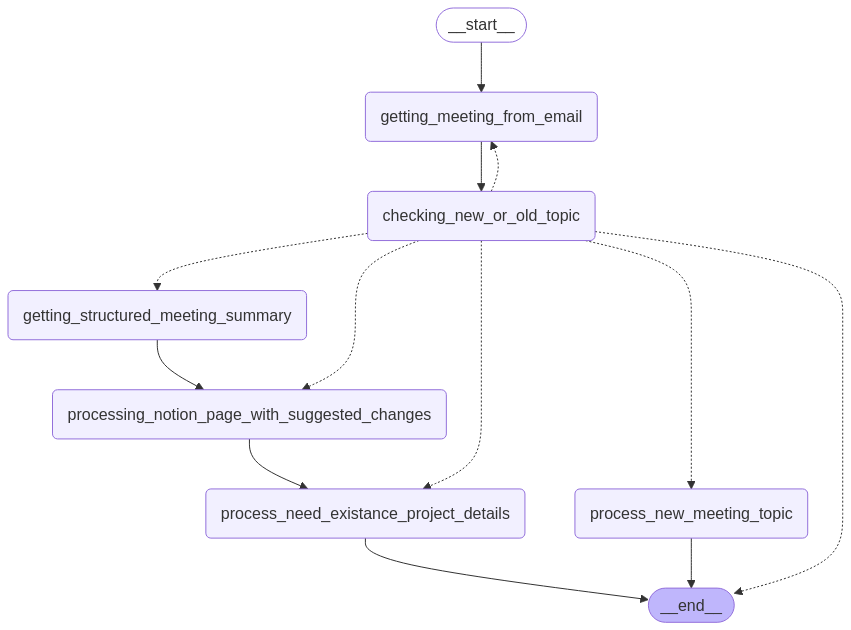

In [13]:
my_agent_builder = StateGraph(MyAgentState1)

#Adding Nodes
my_agent_builder.add_node("getting_meeting_from_email" , getting_meeting_from_email)
my_agent_builder.add_node("checking_new_or_old_topic" , checking_new_or_old_topic)
# my_agent_builder.add_node("sending_msg_to_admin_via_slack" , sending_msg_to_admin_via_slack)
# my_builder.add_conditional_edges("checking_new_or_old_topic" , decide_new_or_changes)
# my_builder.add_node("getting_latest_meeting_summary" , getting_latest_meeting_summary)
# my_builder.add_node("sending_action_items_to_slack_channel" , sending_action_items_to_slack_channel)
my_agent_builder.add_node("getting_structured_meeting_summary" , getting_structured_meeting_summary)
my_agent_builder.add_node("processing_notion_page_with_suggested_changes" , processing_notion_page_with_suggested_changes)
my_agent_builder.add_node("process_need_existance_project_details" , process_need_existance_project_details)
my_agent_builder.add_node("process_new_meeting_topic" , process_new_meeting_topic)
# my_agent_builder.add_node("messaging_admin_via_slack_for_new_notion_page_id" , messaging_admin_via_slack_for_new_notion_page_id)





# Adding Edges
my_agent_builder.add_edge(START, "getting_meeting_from_email")
my_agent_builder.add_edge("getting_meeting_from_email", "checking_new_or_old_topic")
# adding conditional edge to go to either getting_structured_meeting_summary node or sending_msg_to_admin_via_slack
my_agent_builder.add_conditional_edges("checking_new_or_old_topic", decide_new_or_changes)

# my_builder.add_edge("checking_new_or_old_topic" , "sending_msg_to_admin_via_slack")
# my_builder.add_edge("checking_new_or_old_topic" ,"getting_structured_meeting_summary")
my_agent_builder.add_edge("getting_structured_meeting_summary" , "processing_notion_page_with_suggested_changes")
my_agent_builder.add_edge("processing_notion_page_with_suggested_changes" , "process_need_existance_project_details")
my_agent_builder.add_edge("process_need_existance_project_details" , END)
my_agent_builder.add_edge("process_new_meeting_topic" , END)
# my_agent_builder.add_edge("messaging_admin_via_slack_for_new_notion_page_id" , END)

# my_builder.add_edge("getting_latest_meeting_summary" , "sending_action_items_to_slack_channel")
# my_builder.add_edge("sending_action_items_to_slack_channel" , "getting_structured_meeting_summary")
# my_builder.add_edge("getting_structured_meeting_summary" , "processing_each_notion_page_with_req_changes")
# my_builder.add_edge("processing_each_notion_page_with_req_changes" , END)


notion_agent_graph = my_agent_builder.compile()

# Visualize the graph
display(Image(notion_agent_graph.get_graph(xray=True).draw_mermaid_png()))


In [14]:


latest_meeting_summary_1 = """
0:00
Attendance and Leave Updates
Bhoopendra Sharma mentioned that Shahzad and Andy would be joining the meeting late, while Nadia Dsilva confirmed that Nadia Dibakar is on leave. The team discussed the functionality of Keka for tracking attendance and expressed a desire to increase engagement by posting more frequently in their communication channels. Bhoopendra suggested that they could use the platform for birthday wishes and other updates.

3:57
Leave Schedules and Communication Plans
Bhoopendra Sharma confirmed he will be out of the office from February 15 to February 23, with some availability on February 14. Nadia Dsilva will be on leave for three days, specifically February 19, 20, and 21. Salmanul Faris mentioned he may take three to four days off during the third week of February, though he is unsure of the exact dates.

6:18
Project Update on Navigation Agent Development
Bhoopendra Sharma and Pritesh Singh focused on finalizing the navigation agent and completing the data side for the POC by the week's end. They highlighted the importance of clear schemas and discussed the classification of output entities, with Pritesh mentioning the need to connect with Faisal for further clarification. Additionally, they noted the challenges with dynamic carousel pages and pop-ups in the agent's functionality.

19:57
Exploring Platforms for Agentic Workflows
Bhoopendra Sharma highlighted that current agentic workflows can be executed on local machines without requiring GPUs, making it suitable for proof of concept. He tasked Baz with researching the best platforms for running these workflows and mentioned the possibility of using AWS services like Lambda and ECS. Pritesh Singh also encouraged team members to contribute their findings and insights on industry practices.

24:26
Discussion on Vector Databases and Indexing Solutions
Shahbaaz Singh inquired about the indexing model being used, to which Pritesh Singh responded that they are currently relying on OpenAI calls without a specific model. Bhoopendra Sharma mentioned the possibility of using LangRaph and highlighted the need for different setups depending on whether data is retained in memory. The conversation also touched on various vector databases, including FAISS, ChromaDB, and Pinecone.

28:36
Project Updates and Task Assignments
Bhoopendra Sharma provided updates on the navigation project and the status of custom cases, with team members Sharad, Nadia, and Salmanul sharing their progress. Pritesh Singh addressed the unresolved issue with Google searches, mentioning a temporary workaround that is currently in use while a more permanent solution is being developed.

Progress on the navigation agent and its completion timeline.
Updates on custom cases and other ongoing projects.
Team members' leave schedules and approvals.
Feedback from the marketing team on redesigned pages.
Issues with Google searches and the need for a permanent solution.
41:42
Updates on Row Model Testing and Project Timelines
Sharad Korekar outlined plans to update the upstream URL to facilitate testing of the row model by the QA team, who will identify issues with specific documents. Bhoopendra Sharma noted that the current focus is on pensions, with no live operations, allowing for a thorough end-to-end completion before moving to the EV project. Additionally, there was a discussion about downgrading the TV and ensuring that necessary changes are made in the dev step function.

46:58
GitHub Access and Agent Development Updates
Bhoopendra Sharma announced that all team members have been added to the GitHub team and urged them to complete their accounts. Keerthi Lakshmi Buchupalli reported that they have finished the documentation and initial steps for their agent, while Ananya Sahu mentioned ongoing work on prompt creation. The team also discussed the need for documentation and integration with Notion APIs for their projects."

"""
latest_meeting_summary_2 = """
    2:23
    High-Level Discussion on Axial Project
    Bhoopendra Sharma led a discussion focused on the Axial project, emphasizing the importance of wrapping up discussions this week to begin development next week. Pritesh Singh was involved in locating and sharing a high-level diagram that outlines the Axial process flow, which was essential for the ongoing conversation.
    8:58
    Overview of XCL and Its Marketplace
    Bhoopendra Sharma introduced XCL, a client that operates as a marketplace for mergers and acquisitions, likening it to a real estate broker. He detailed how the platform allows users to register as either buyers or sellers, facilitating interactions and transactions. The focus is on collecting and validating information about companies on the platform to ensure accurate data for both sides.
    Overview of XCL and its business model
    15:04
    Data Collection and Pipeline Development for XCL
    Bhoopendra Sharma outlined the objectives of the XCL project, focusing on collecting data through news scraping, portfolio member scraping, and social media scraping. He explained the need for an end-to-end pipeline that will handle data in batches, synthesizing information from multiple sources to provide comprehensive profiles for investors and sellers. Pritesh Singh contributed by offering to share company links to aid in the explanation.
    29:22
    Data Collection and Pipeline Overview
    Bhoopendra Sharma outlined the data collection strategy, which includes three verticals: news, portfolio pages, and social media. He noted that while the portfolio section is already developing several agents, the news pipeline currently lacks agents but may require them in the future. The collected data will be processed in batches, and classification will be essential to ensure relevance before final output delivery.
    Data collection methods and processes
    39:10
    News and End-to-End Pipeline Development
    Bhoopendra Sharma discussed the creation of a news pipeline and an end-to-end pipeline that will incorporate news, portfolio members, and social media. Pritesh is responsible for the news pipeline, while Baaz and Sharad will oversee the end-to-end pipeline. The three verticals will share the same input data, producing combined outputs for investors.
    Development of the news pipeline
    44:37
    Discussion on New Agentic Pipeline Development
    Bhoopendra Sharma outlined the responsibilities of team members, including Pritesh, Baaz, and Shahbaaz, in developing a new agentic pipeline. He mentioned the need to connect with the social media team and portfolio members while focusing on the integration of agents into the pipeline. The team is tasked with determining the best platforms and designs for the pipeline, which is still in the early stages of development.
    Roles and responsibilities for the project
"""
latest_meeting_topic_1 = "Hive Reveiws and Demos"
latest_meeting_topic_2 = "Axial Project Pipeline"


latest_action_items_data_1 = """
    Action Items:
    * Pritesh Singh will complete the navigation feature by end of day today.
    * Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.
    * Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.
    * Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.
    * Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.
    * Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.
    * Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.
    * Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.
    """
# agent_response = notion_agent_graph.invoke({"latest_meeting_topic" : latest_meeting_topic_2 , "latest_email_meeting_summary" : latest_meeting_summary_2 , "latest_action_items_data" : latest_action_items_data})
latest_action_items_data_2 = """
    "action_items": [
        {"user": "Bhoopendra Sharma", "task": "Use the specified classification for the data extraction process in the next steps."},
        {"user": "Pritesh Singh", "task": "Share a company link for the buy side and sell side to assist in explaining the project."},
        {"user": "Pritesh Singh", "task": "Lead the development of the news pipeline end-to-end and coordinate with the team."},
        {"user": "Bhoopendra Sharma", "task": "Ensure that documentation is started and information on models is prepared for the project."},
        {"user": "Bhoopendra Sharma", "task": "Set up a call with all stakeholders by Thursday to introduce the team working on the pipeline and discuss support needed."}
    """

async def main():
    agent_response = await notion_agent_graph.ainvoke({
        "latest_meeting_topic": latest_meeting_topic_1,
        "latest_email_meeting_summary": latest_meeting_summary_1,
        "latest_action_items_data": latest_action_items_data_1
    })

    print(" Agent Response:", agent_response)

await main()

Here we will get both Topic and Latest Email Summary as Input from Agent Invoking
Invoked getting_meeting_from_email
Getting latest Meeting to Invoke Agent
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Latest Meeting topic got is Hive Reveiws and Demos
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
LATEST MEETING SUMMARY IS 


0:00
Attendance and Leave Updates
Bhoopendra Sharma mentioned that Shahzad and Andy would be joining the meeting late, while Nadia Dsilva confirmed that Nadia Dibakar is on leave. The team discussed the functionality of Keka for tracking attendance and expressed a desire to increase enga

In [ ]:



# # Trialing the processes


# print("Getting a Structured Refined Summary from an LLM in the form of a List of Dicts")
# print("Getting existing Notion Pages Content")
# # pages_id_list = ["18ae35223beb804fbfb3cce77e9a94fb" , "196e35223beb806a8889f2524d28bdaf"]
# pages_id_list = fetch_data_from_notion_pages_data_database_table("1a3e35223beb806e80acdc2563180fb1")
# print(pages_id_list)
# # pages_id_list = [{notion_page_id : "" , page_project_title : ""}]

# notion_pages_data = []
# # overall_notion_data  = ""
# for each_notion_page_info  in pages_id_list:
#     notion_page_id = each_notion_page_info.get("notion_page_id")
#     each_dict = dict()
#     each_dict["page_id"] = notion_page_id
#     # notion_page_info = {"notion_page_id": eachPageId}
#     # print(f"Debug Notion Page Info: {notion_page_info}")  # Debugging Step
#     each_dict["fetched_content"] = str(fetch_notion_page_content.invoke(input = {"notion_page_id_info" : {"notion_page_id" :notion_page_id }} ))
#     notion_pages_data.append(each_dict)
#     print("🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢")
#     # print(each_dict["fetched_content"])
# print("Fetching Data from All Notion Pages Completed")
# # state["pre_existing_notion_page_data"] = notion_pages_data   # list of strings
# for each_dict in notion_pages_data:
#     print("*********************")
#     print(each_dict["page_id"])
#     print(each_dict["fetched_content"])
#     print("*************************")
# print("All Fetching completed , now it will be precessed by LLM to get list of changes to be made for each Notion Page")
# # Processing Notion Content and comparing with Latest Meeting summary
# # latest_meeting_summary = state["latest_email_meeting_summary"]
# latest_meeting_summary = "The meeting covered progress updates on various agents, including navigation, marketing, documentation, and IDP agents. Key discussions included the integration of SEMrush, Notion API exploration, and improvements to the IDP agent. Action items were assigned to team members to ensure timely execution and pipeline visibility."
# action_items = [
#     {
#         "user": "Pritesh Singh",
#         "task": "Prepare a demo for the Excel pipeline to provide team visibility."
#     },
#     {
#         "user": "Keerthi Lakshmi Buchupalli",
#         "task": "Resolve SEMrush API error and proceed with Selenium-based integration."
#     },
#     {
#         "user": "Ganesh Putta",
#         "task": "Continue exploring Notion API for documentation updates and action item tracking."
#     },
#     {
#         "user": "Ananya Sahu",
#         "task": "Optimize IDP agent workflow by incorporating dynamic processing and human-in-the-loop validation."
#     },
#     {
#         "user": "Vaibhav Thakran",
#         "task": "Enhance IDP agent's table extraction accuracy and explore alternative models."
#     },
#     {
#         "user": "Pritesh Singh",
#         "task": "Share OpenAI API key with Ananya Sahu for further development."
#     },
#     {
#         "user": "Salmanul Faris",
#         "task": "Catch up on BLK project deliverables and ensure timely completion of required URLs."
#     },
#     {
#         "user": "Diwakar Joshi",
#         "task": "Get familiar with assigned agent framework and tools."
#     }
# ]
# # action_items = state["latest_action_items_data"]
# # pre_existing_notion_page_data = state["pre_existing_notion_page_data"]
# print("Down Processing Stage")
# all_page_changes = []
# prompt = f"""
# You are an AI assistant responsible for structuring meeting insights by mapping the latest meeting summary to relevant projects in Notion. Your task is to analyze the latest refined meeting summary and extracted action items while leveraging the provided `pages_id_list` context.
# ## **Input Data**:
# 1. **Latest Refined Meeting Summary**:
# {latest_meeting_summary}

# 2. **Extracted Action Items**:
# {json.dumps(action_items, indent=4)}

# 3. **Existing Notion Project Records (pages_id_list)**:
# The list of Notion pages and their corresponding project names:
# ```json
# {json.dumps(pages_id_list, indent=4)}
# Your Task:
# 1. Analyze the latest meeting summary and extracted action items.
# 2. Utilize pages_id_list to structure the information based on existing Notion project mappings.
# 3. Identify both pre-existing projects from pages_id_list and new projects that are discussed in the meeting but not found in pages_id_list.
# 4. For each project (existing or new), generate a structured summary that includes:
#     - Clearly describing the project status in a full sentence format (e.g., "The project is currently in the deployment phase and is nearing completion." instead of "Status: Deployment in progress").
#     - Summarizing any challenges if they exist.
#     - Listing the tasks completed relevant to the project.
# Handling New Projects:
# If a project mentioned in latest_meeting_summary does not exist in pages_id_list, include it in the output with:
#     - "notion_id": "need_existence" (indicating a new Notion page should be created).
#     - "project_name": "<new project name>".
#     - "points_list" summarizing key insights in full sentence format.
# Output Format:
# The response must strictly be a JSON list of dictionaries, structured as follows:

# json```
# [
#     {{
#         "notion_id": "<notion_page_id>",
#         "project_name": "<project_name>",
#         "points_list": [
#             "<full sentence about project status>",
#             "<full sentence about any challenges (if any)>",
#             "<full sentence about completed tasks>"
#         ]
#     }},
#     {{
#         "notion_id": "need_existence",
#         "project_name": "<new_project_name>",
#         "points_list": [
#             "<full sentence about project status>",
#             "<full sentence about any challenges (if any)>",
#             "<full sentence about completed tasks>"
#         ]
#     }}
# ]
# Output Constraints:
# The points_list must be in complete sentences that provide clear and structured information.
# If multiple Notion pages exist, generate separate structured outputs for each corresponding project.
# If multiple new projects are identified in latest_meeting_summary, include each one separately with "notion_id": "need_existence".
# Ensure that all discussed projects from latest_meeting_summary appear in the final output, whether pre-existing or newly identified.
# Example Output:
# json```
# [
#     {{
#         "notion_id": "12345",
#         "project_name": "Marketing Agent",
#         "points_list": [
#             "The Marketing Agent project is currently integrating the SEMrush API to enhance data analysis capabilities.",
#             "There is a challenge in resolving an API error encountered during integration.",
#             "The team is actively working on the integration and has assigned tasks to resolve errors."
#         ]
#     }},
#     {{
#         "notion_id": "67890",
#         "project_name": "Documentation Agent",
#         "points_list": [
#             "The Documentation Agent project is in the exploration phase for utilizing the Notion API.",
#             "Challenges remain in fully understanding and implementing the required API features.",
#             "Tasks have been assigned to explore the API for enhancing documentation practices."
#         ]
#     }},
#     {{
#         "notion_id": "need_existence",
#         "project_name": "AI Research Assistant",
#         "points_list": [
#             "The AI Research Assistant project is in the early discussion phase to assist with document summarization.",
#             "A key challenge is optimizing response time for real-time query handling.",
#             "The team is exploring different language models to improve accuracy and efficiency."
#         ]
#     }},
#     {{
#         "notion_id": "need_existence",
#         "project_name": "SEO Optimizer",
#         "points_list": [
#             "The SEO Optimizer project aims to integrate multiple data sources for keyword tracking.",
#             "A major hurdle is automating data extraction from various sources without violating rate limits.",
#             "The next steps include setting up API connections and validating extracted insights."
#         ]
#     }}
# ]
# ```
# **Ensure the response is strictly in JSON format without additional explanations.**
# """
# llm_response =  llm.invoke(prompt)
# llm_response_content = llm_response.content
# cleaned_json_str = re.sub(r'^```json\n|\n```$', '', llm_response_content.strip())
# cleaned_json_object = json.loads(cleaned_json_str)
# print("############################################################################")
# print(json.dumps(cleaned_json_object , indent = 4))
# print("############################################################################")

JSONDecodeError: Expecting ',' delimiter: line 1 column 1396 (char 1395)

In [ ]:
# Trialing the processes





# extracted_project_details_from_lms = {
#     "projects": [
#         {
#             "notion_id": "id1",
#             "project_name": "Marketing Agent",
#             "details": [
#                 "The team was in the initial planning phase, evaluating different SEO tools for integration.",
#                 "Faced challenges in selecting the most compatible SEO tool for automation.",
#                 "Initial attempts at SEMrush integration resulted in authentication errors.",
#                 "Explored alternative automation tools but lacked a proper API approach."
#             ]
#         },
#         {
#             "notion_id": "id2",
#             "project_name": "Documentation Agent",
#             "details": [
#                 "The Documentation Agent was not yet started, pending approval for Notion API usage.",
#                 "Faced difficulties in understanding Notion API's rate limits and data structuring.",
#                 "Initial tests showed inconsistencies in retrieving document history.",
#                 "Action item tracking within Notion was not yet implemented."
#             ]
#         },
#         {
#             "notion_id": "page_id",
#             "project_name": "BLK Project",
#             "details": [
#                 "The BLK project was in the early research phase with incomplete project scope.",
#                 "Delays were observed due to unclear requirements and changing priorities.",
#                 "Team faced challenges in aligning URLs with the required project structure.",
#                 "Lack of proper tracking mechanisms led to slower progress."
#             ]
#         },
#         {
#             "notion_id": "page_id",
#             "project_name": "IDP Agent",
#             "details": [
#                 "The IDP Agent development was in an experimental stage with basic document processing.",
#                 "Early table extraction attempts showed poor accuracy in structured document layouts.",
#                 "The workflow was mostly static, lacking flexibility for dynamic document formats.",
#                 "No human-in-the-loop validation mechanism was implemented initially.",
#                 "Challenges were faced in choosing the right ML models for document classification."
#             ]
#         }
#     ]
# }



# for each_extracted_project_details_from_lms in extracted_project_details_from_lms:
#         extracted_notion_page_id = each_extracted_project_details_from_lms["notion_id"]
#         extracted_points_list = each_extracted_project_details_from_lms["points_list"]  # Comparision-3
#         if extracted_notion_page_id == "need_existence":
#             continue
#         fetched_notion_content  = get_respective_notion_page_content_by_page_id(extracted_notion_page_id)    # Comparision-2
#         print("Fetched Content is \n")
#         # print(fetch_notion_page_content)
#         latest_project_data_row = get_latest_projects_row_data(extracted_notion_page_id)
#         latest_project_data_list = latest_project_data_row["latest_data"]    #Comparison-1
#         print("Latest Project Data_List is \n")
#         # print(latest_project_data_list)
#         # now extracted_points_list will be compared with  fetched_notion_content and old_meeting respective project points(fetched from a table) 
#         prompt = f"""You are an AI assistant responsible for analyzing project updates and refining structured data based on meeting summaries. Your task involves comparing extracted key points from a new meeting summary (`extracted_points_list`) with previously logged project details (`latest_project_data_list`) and existing Notion page content (`fetched_notion_content`).  

#         ### **Comparison-1: Generate Change Logs for Project Updates**  
#         Compare `extracted_points_list` with `latest_project_data_list` to identify updated project details.  
#         ### **extracted_points_list (list of points)**
#          {json.dumps(extracted_points_list)}
#         ### **latest_project_data_list (list of points)**
#          {json.dumps(latest_project_data_list)}


#         - Identify differences between `extracted_points_list` (latest extracted details) and `latest_project_data_list` (previously recorded details).  
#         - If new progress, challenges, or decisions are recorded in `extracted_points_list` but not in `latest_project_data_list`, summarize the changes in a **human-readable format**.  
#         - Ensure updates are concise, structured, and easy to understand.  

#         #### **Output format for Comparison-1:**  
#         Generate a JSON object with a `effective_change_logs` field, which contains an array of human-readable updates:  

#         ```json
#         {
#             "effective_change_logs": [
#                 "<change-1>",
#                 "<change-2>",
#                 "<change-3>",
#                 "<update-4>",
#                 "<update-5>"
#             ]
#         }

#         ### ** Comparison-2: Updating Notion Page Content ** 
#         Compare extracted_points_list with fetched_notion_content to determine necessary modifications to the existing structured Notion content.
#         - Identify where extracted_points_list contains new information that should be reflected in fetched_notion_content.
#         - Determine whether each update requires adding, appending, updating, or deleting content.
#         - Ensure that hierarchical structure and contextual relevance are preserved.
#         ### **extracted_points_list (list of points)**
#          {json.dumps(extracted_points_list)}
#         ### **extracted_points_list (Notion Page Data)**
#          {fetched_notion_content}

#         ### **Structure of Each Notion Page Content**
#         Each Notion Page consists of the following **Main Sections**:

#         1. **ChangeLog** → A record of past modifications to the page.
#         - The **ChangeLog section** can be identified by entries in the following format:
#             "Change Log - Date: 02/05/2025: {{id: 18be3522-3beb-80bb-9ed9-db0db98e9c3b}}"
#         - Each entry contains a **date** and a **unique identifier (UUID)** that tracks modifications.

#         2. **Latest Notes** → Contains multiple **topics related to the project**.  
#         - All content under this section **belongs to Latest Notes**.  
#         - These topics are structured **hierarchically** and follow a numerical outline format.  
#         - The **ChangeLog** will have its own numbering (e.g., **2, 3, 4, etc.**) and is separate from **Latest Notes**.  
#         - If **Latest Notes** starts at line **6**, then topics will follow a hierarchical structure:  
#             - **Topics:** 6.1, 6.2, 6.4, etc.  
#             - **Subtopics under topics:** 6.1.1, 6.1.2, 6.2.1, 6.2.2, 6.4.1, 6.4.2, etc.  
#         - Each topic represents a **key discussion point from past meetings**.  
#         - **If a topic name needs to be modified, ensure that the new topic name is clear, concise, and does not contain lengthy sentences.**  
#         - The topic name should be **short, relevant, and to the point**, avoiding unnecessary details.  

#         3. **Action Items (within Latest Notes)** → The last part of the **Latest Notes** contains actionable tasks written in:
#         - **Sentence format** (e.g., "Update the API documentation.")
#         - **Bullet points** (e.g., "- Finalize testing for module X.")


#         ** Output format for Comparison-2:
#         Generate a JSON object with changes, notion_changeLogs, effective_changeLogs, and suggested_action_items_add fields.
#         - **"changes"** → A list of JSON objects containing all modifications to be applied.
#     #     - **"changeLogs"** → A separate list of human-readable descriptions of what changed.
#     #     - **"suggested_action_items_add"** → A list of dictionaries, where each dictionary contains:
#     #     - `"action_item_text"` → The action item task text.
#     #     - `"assignees"` → A list of names of the people assigned to the task.
#     #     - `"status"` → The status of the task (default is `"In Progress"` if no status is specified).

    

#         {
#             "page_id": "{extracted_notion_page_id}",
#             "changes": [
#                 {
#                     "LineId": "<lineid>",
#                     "objectId": "<ObjectId of the line with LineId>",
#                     "ChangeType": "<add, append, update, delete>",
#                     "function_to_be_used": "<function name according to ChangeType>",
#                     "ContentForChange": "<New content that needs to be modified or added.>"
#                 }
#             ],
#             "notion_changeLogs": [
#                 "<Human-readable log entry describing the change>"
#             ],
#             "suggested_action_items_add": [
#                 {
#                     "action_item_text": "<Action item task>",
#                     "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
#                     "status": "In Progress"
#                 }
#             ]
#         }
#     """
        
#         response = llm.invoke(prompt)  
#         response_content = response.content

#         # Clean the response (remove markdown `json` formatting if any)
#         cleaned_json_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())

#         try:
#             json_data = json.loads(cleaned_json_str)
#             page_changes = {
#                 "page_id": extracted_notion_page_id,
#                 "changes": json_data.get("changes", []),
#                 "changeLogs": json_data.get("notion_changeLogs", []),
#                 "suggested_action_items_add" : json_data.get("suggested_action_items_add" , [])
#             }
#             print(page_changes)
#             all_page_changes.append(page_changes)  # Append each page's changes
#             print("Changes extraction completed , waiting for a period")
#             time.sleep(3)
#             print("Waiting completed")

#         except json.JSONDecodeError as e:
#             print(f"Error decoding JSON for page {extracted_notion_page_id}: {e}")